In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_excel('../data/processed/df_prepared.xlsx')

In [6]:
df.rename(columns={'FU1+2+3 coronary event (Death+AMI+ACS+Revasc)': 'target'}, inplace=True)

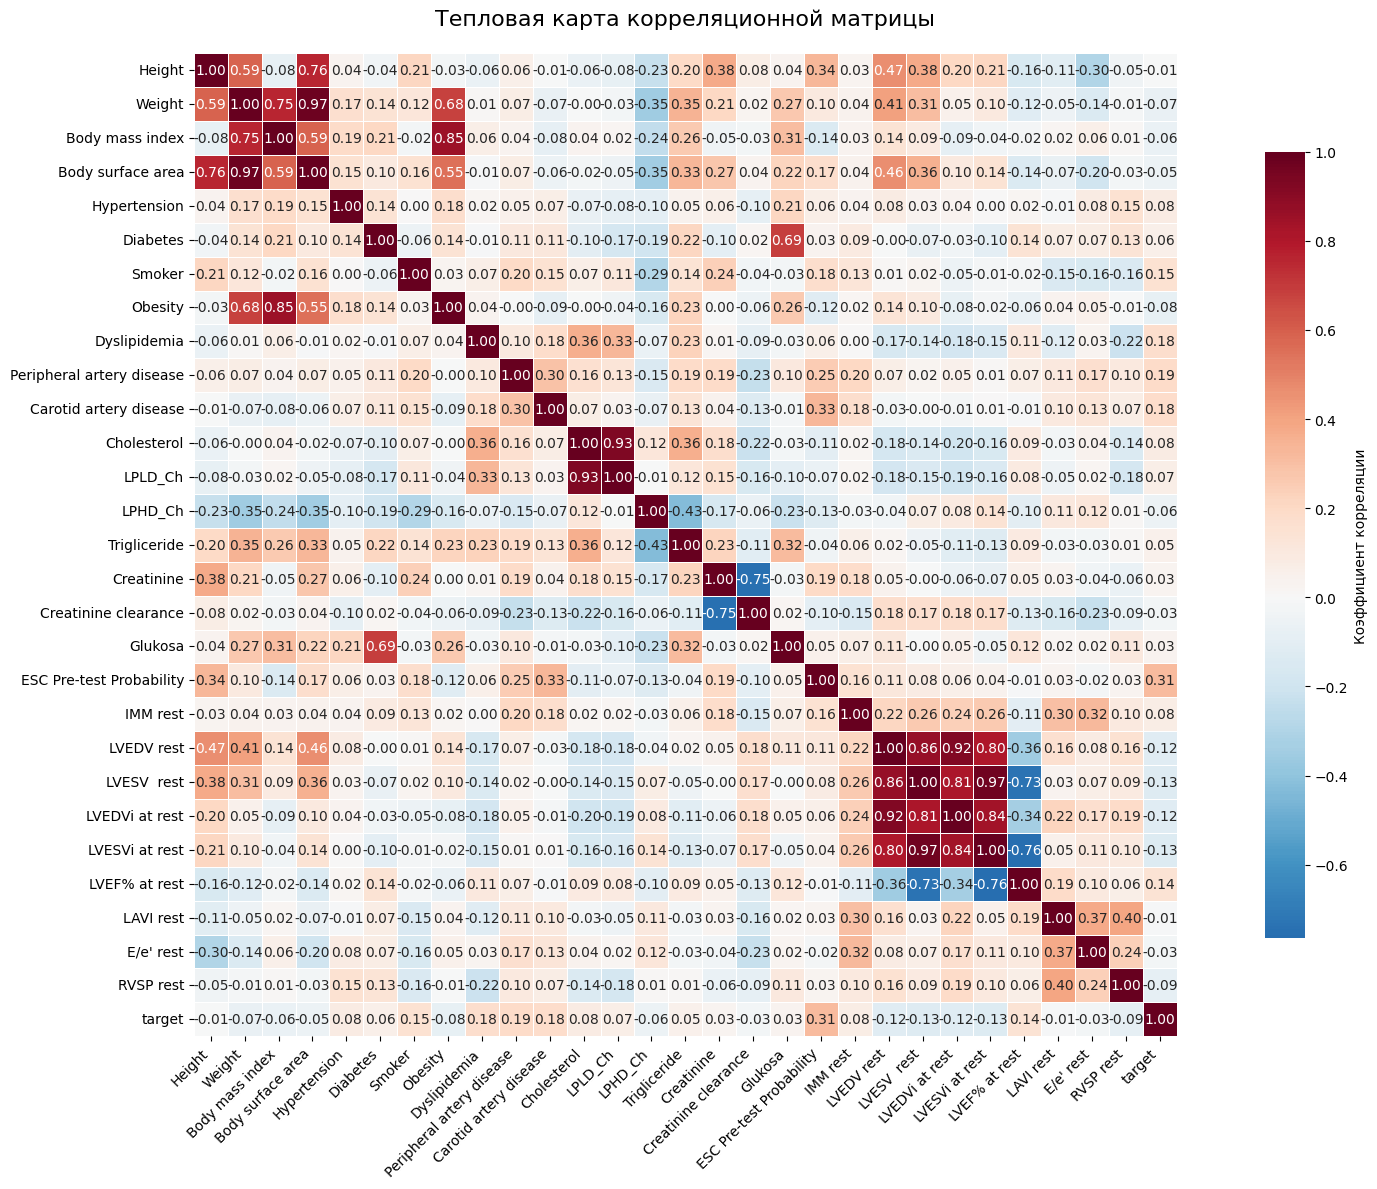

In [13]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(), 
            annot=True,  # Показывать значения
            fmt='.2f',   # Формат чисел
            cmap='RdBu_r',  # Цветовая схема
            center=0,    # Центр цветовой шкалы
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Коэффициент корреляции'})

plt.title('Тепловая карта корреляционной матрицы', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
df.columns

Index(['Height', 'Weight', 'Body mass index', 'Body surface area',
       'Hypertension', 'Diabetes', 'Smoker', 'Obesity', 'Dyslipidemia',
       'Peripheral artery disease', 'Carotid artery disease', 'Cholesterol',
       'LPLD_Ch', 'LPHD_Ch', 'Trigliceride', 'Creatinine',
       'Creatinine clearance', 'Glukosa', 'ESC Pre-test Probability',
       'IMM rest', 'LVEDV rest', 'LVESV  rest', 'LVEDVi at rest',
       'LVESVi at rest', 'LVEF% at rest', 'LAVI rest', 'E/e' rest',
       'RVSP rest', 'target'],
      dtype='object')

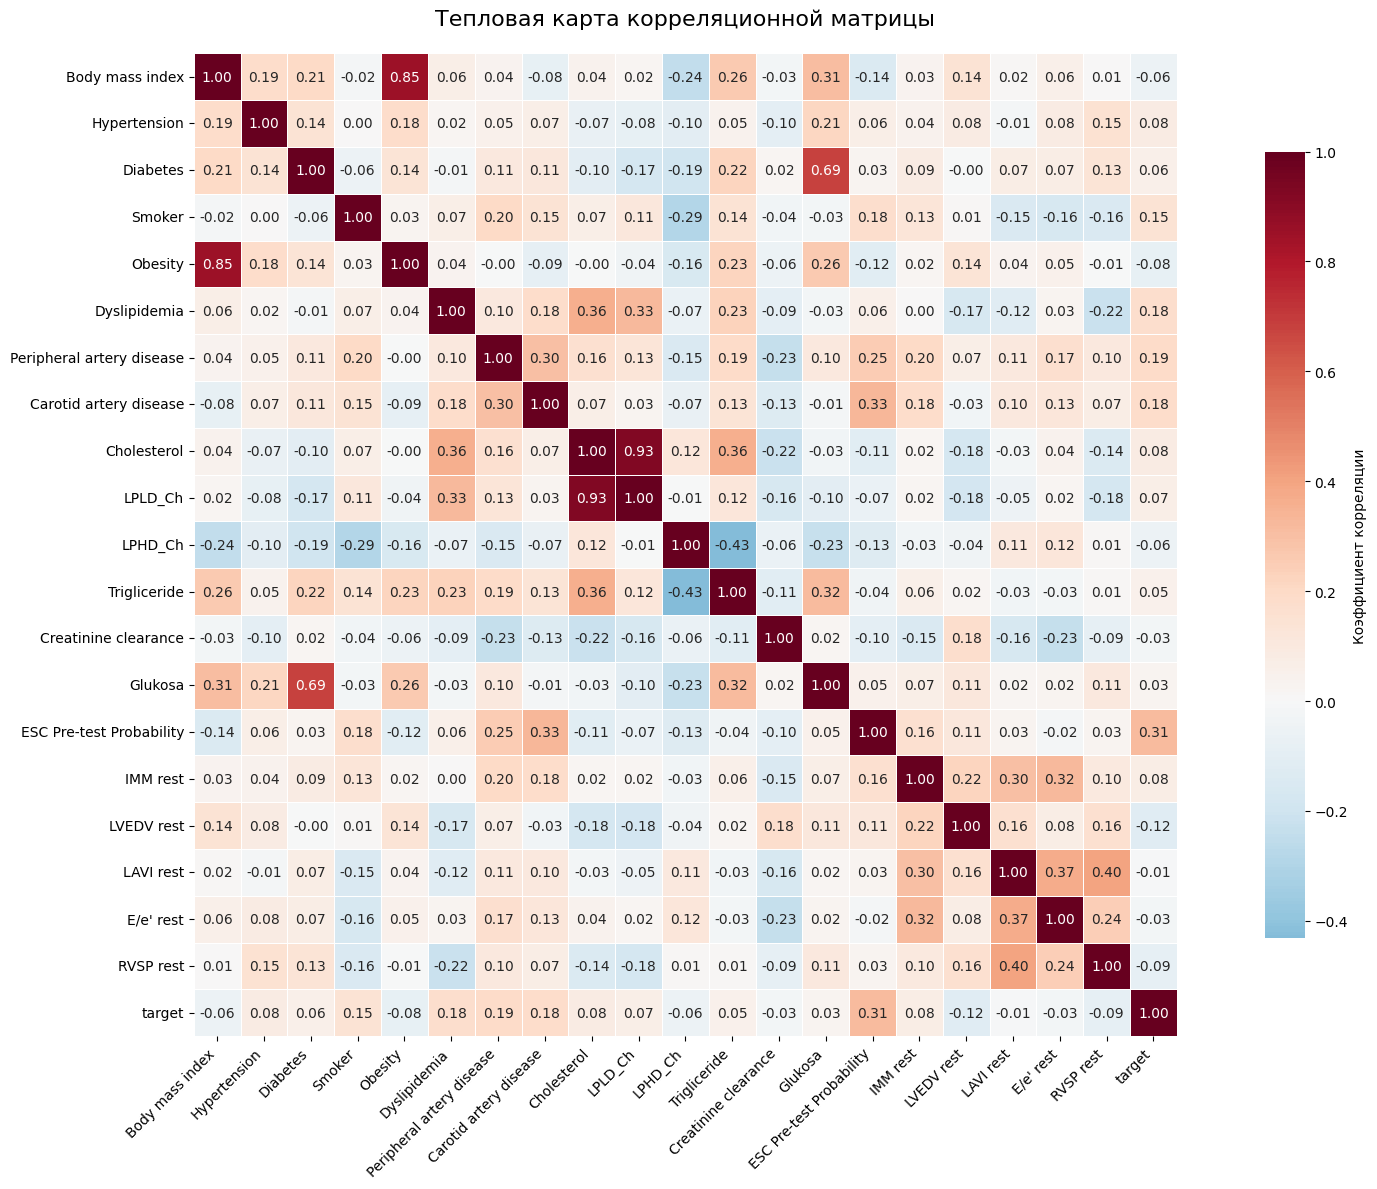

In [32]:
corr_cols = ['Body surface area', 'Height', 'Weight', 'Creatinine', 'LVESV  rest', 'LVEDVi at rest',
       'LVESVi at rest', 'LVEF% at rest']
plt.figure(figsize=(18, 12))
sns.heatmap(df.drop(columns = corr_cols).corr(), 
            annot=True,  # Показывать значения
            fmt='.2f',   # Формат чисел
            cmap='RdBu_r',  # Цветовая схема
            center=0,    # Центр цветовой шкалы
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Коэффициент корреляции'})

plt.title('Тепловая карта корреляционной матрицы', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [33]:
X_dropped = df.drop(columns=['target'] + corr_cols)

In [34]:
def mutual_info_feature_selection(X, y, n_features=None, threshold=None, random_state=42):
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    
    mi_series = pd.Series(mi_scores, index=X.columns if hasattr(X, 'columns') else range(X.shape[1]))
    mi_series = mi_series.sort_values(ascending=False)
    
    if n_features is not None:
        selected_features = mi_series.head(n_features).index.tolist()
    elif threshold is not None:
        selected_features = mi_series[mi_series >= threshold].index.tolist()
    else:
        selected_features = mi_series[mi_series > 0].index.tolist()
    
    return selected_features, mi_series

selected_features, mi_series = mutual_info_feature_selection(X_dropped, df['target'], n_features=10)
print("Выбранные признаки:", selected_features, "\nMI Scores:\n", mi_series)

Выбранные признаки: ['ESC Pre-test Probability', 'Trigliceride', 'Smoker', 'Dyslipidemia', 'Carotid artery disease', 'Hypertension', 'Peripheral artery disease', 'LPLD_Ch', 'Body mass index', "E/e' rest"] 
MI Scores:
 ESC Pre-test Probability     0.073094
Trigliceride                 0.048319
Smoker                       0.031369
Dyslipidemia                 0.025460
Carotid artery disease       0.021062
Hypertension                 0.017975
Peripheral artery disease    0.005821
LPLD_Ch                      0.001509
Body mass index              0.000000
E/e' rest                    0.000000
LAVI rest                    0.000000
LVEDV rest                   0.000000
IMM rest                     0.000000
LPHD_Ch                      0.000000
Glukosa                      0.000000
Creatinine clearance         0.000000
Cholesterol                  0.000000
Obesity                      0.000000
Diabetes                     0.000000
RVSP rest                    0.000000
dtype: float64


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)
df_X_scaled = pd.DataFrame(X_scaled, columns=X_dropped.columns.tolist())
df_X_scaled.head()

,Body mass index,Hypertension,Diabetes,Smoker,Obesity,Dyslipidemia,Peripheral artery disease,Carotid artery disease,Cholesterol,LPLD_Ch,LPHD_Ch,Trigliceride,Creatinine clearance,Glukosa,ESC Pre-test Probability,IMM rest,LVEDV rest,LAVI rest,E/e' rest,RVSP rest
0,-0.436985,0.416154,-0.342084,-0.531257,-0.055290,0.468289,-0.847720,0.63134,2.385494,2.665827,0.288150,-0.251919,-0.772976,-1.210336,-1.116290,-0.419939,-0.912494,-0.327225,-1.216699,-0.093772
1,0.481986,0.416154,-0.342084,-0.531257,1.396061,0.468289,-0.847720,0.63134,0.414619,0.195984,0.664207,0.020089,-1.858870,0.345282,-0.284125,-0.065196,-0.193058,0.285727,0.518672,0.179666
2,-0.977476,-2.402955,-0.342084,1.085612,-1.506641,0.468289,1.202907,0.63134,0.358764,0.528668,-0.313517,-0.070580,-0.350684,-0.380673,-0.700208,0.162547,-0.531616,-0.513767,-0.894984,-0.323156
3,-0.681052,0.416154,-0.342084,-0.531257,-0.055290,0.468289,-0.847720,-1.59281,-0.782269,-0.786022,0.611963,-0.614597,0.192263,-0.795505,-1.116290,-0.276467,-0.446977,-0.145975,0.050830,0.001960
4,-0.213131,0.416154,-0.342084,-0.531257,-0.055290,0.468289,-0.847720,0.63134,0.821561,0.510932,1.382092,-0.100803,-0.531666,-0.691797,-1.449156,-0.730383,-0.446977,-0.023771,-0.025614,-0.031045


In [36]:
logreg = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

rfecv_logreg = RFECV(
    estimator=logreg,
    step=1,                   
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',       # можно заменить на 'roc_auc'
    min_features_to_select=5, # минимум 5 признаков
    n_jobs=-1
)

y = df['target'].copy()
rfecv_logreg.fit(X_scaled, y)

# Результаты
print(f"Оптимальное количество признаков: {rfecv_logreg.n_features_}")
print(f"Лучший score (CV): {rfecv_logreg.cv_results_['mean_test_score'].max():.4f}")

# Отобранные признаки
selected_features_logreg = df_X_scaled.columns[rfecv_logreg.support_].tolist()
print(f"Отобранные признаки ({len(selected_features_logreg)}):")
for i, feat in enumerate(selected_features_logreg[:10], 1):
    print(f"  {i}. {feat}")

Оптимальное количество признаков: 9
Лучший score (CV): 0.4221
Отобранные признаки (9):
  1. Hypertension
  2. Dyslipidemia
  3. Peripheral artery disease
  4. Cholesterol
  5. LPLD_Ch
  6. Creatinine clearance
  7. ESC Pre-test Probability
  8. LVEDV rest
  9. RVSP rest


In [37]:
# 4. RFECV со случайным лесом
print("RFECV со Случайным Лесом")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rfecv_rf = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    min_features_to_select=5,
    n_jobs=-1
)

rfecv_rf.fit(df_X_scaled, y)

print(f"Оптимальное количество признаков: {rfecv_rf.n_features_}")
print(f"Лучший score (CV): {rfecv_rf.cv_results_['mean_test_score'].max():.4f}")

selected_features_rf = df_X_scaled.columns[rfecv_rf.support_].tolist()
print(f"Отобранные признаки ({len(selected_features_rf)}):")
for i, feat in enumerate(selected_features_rf[:10], 1):
    print(f"  {i}. {feat}")


RFECV со Случайным Лесом
Оптимальное количество признаков: 9
Лучший score (CV): 0.2821
Отобранные признаки (9):
  1. Body mass index
  2. Cholesterol
  3. LPLD_Ch
  4. LPHD_Ch
  5. Trigliceride
  6. Glukosa
  7. ESC Pre-test Probability
  8. LVEDV rest
  9. E/e' rest


In [38]:
# 5. RFECV с градиентным бустингом
print("RFECV с Градиентным Бустингом")

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

rfecv_gb = RFECV(
    estimator=gb,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    min_features_to_select=5,
    n_jobs=-1
)

rfecv_gb.fit(df_X_scaled, y)

print(f"Оптимальное количество признаков: {rfecv_gb.n_features_}")
print(f"Лучший score (CV): {rfecv_gb.cv_results_['mean_test_score'].max():.4f}")

selected_features_gb = df_X_scaled.columns[rfecv_gb.support_].tolist()
print(f"Отобранные признаки ({len(selected_features_gb)}):")
for i, feat in enumerate(selected_features_gb[:10], 1):
    print(f"  {i}. {feat}")



RFECV с Градиентным Бустингом
Оптимальное количество признаков: 5
Лучший score (CV): 0.2230
Отобранные признаки (5):
  1. Body mass index
  2. LPHD_Ch
  3. Trigliceride
  4. ESC Pre-test Probability
  5. E/e' rest
